# Hearing a Rectangle (Fourieranalyse)

In [6]:
# Imports
#
# C:\Users\sulta\AppData\Local\Programs\Python\Python310\Scripts\pip install scipy
#
import numpy as np
from scipy import stats, signal
import matplotlib.pyplot as plt
import itertools

In [7]:
# Parameter des "wahren" Rechtecks
a_true = 1.0
b_true = 3.0
pi = np.pi

# ausreichend große Modezahlen
m_max, n_max = 800, 800

ms = np.arange(1, m_max + 1)
ns = np.arange(1, n_max + 1)
M, N = np.meshgrid(ms, ns, indexing="ij")

# Dirichlet-Eigenwerte: λ_{m,n} = π²(m²/a² + n²/b²)
lambdas = pi**2 * (M**2 / a_true**2 + N**2 / b_true**2)

# Flatten & sort
l_sorted = np.sort(lambdas.ravel())

# Anzahl der gewünschten Eigenwerte
Nvals = 10000

# überspringt die ersten 5 (Python ist 0-based, Mathematica dagegen 1-based)
start_index = 5
end_index = start_index + Nvals

eigvals = l_sorted[start_index:end_index]

print("Erste 12 Eigenwerte (gerundet):")
print([round(float(x), 4) for x in eigvals[:12]])

Erste 12 Eigenwerte (gerundet):
[40.575, 43.8649, 49.348, 49.348, 57.0244, 63.6041, 66.894, 78.9568, 80.0535, 89.9231, 93.2129, 93.2129]


In [8]:
def reconstruct_aspect_ratio_fourier_analysis(eigvals, N_total_fit=9500):
    """
    Rekonstruiert die Seitenlängen (a, b) und R = a/b mittels der Fourier-Analyse 
    der spektralen Fluktuationen (Geometrisch/Spektrale Dualität).
    
    Diese Methode ist index-frei und nutzt die Periodizität des Spektrums.
    
    Args:
        eigvals (list oder np.ndarray): Die sortierten Eigenwerte (λ_k).
        N_total_fit (int): Anzahl der Eigenwerte, die für die Analyse verwendet werden.
        
    Returns:
        tuple: (rekonstruiertes_a, rekonstruiertes_b, rekonstruiertes_R)
    """
   
    N_total = min(len(eigvals), N_total_fit)
    eigvals = np.array(eigvals[:N_total])
    k_vals = np.arange(1, N_total + 1)
    
    # ----------------------------------------------------
    ## 1. Schritt: Rekonstruktion der Fläche (A = ab)
    # ----------------------------------------------------
    start_index_A = int(0.3 * N_total)
    slope_A, _, _, _, _ = stats.linregress(eigvals[start_index_A:], k_vals[start_index_A:])
    A_hat = 4 * pi * slope_A
    print(f"--- Schritt 1: Fläche (Area) ---")
    print(f"Rekonstruierte Fläche A = a*b ≈ {A_hat:.4f} (Wahr: {a_true*b_true:.1f})")

    # ----------------------------------------------------
    ## 2. Schritt: Analyse der Spektralen Fluktuationen
    # ----------------------------------------------------
    print(f"\n--- Schritt 2: Fourier-Analyse (Bestimmung der Längen L=2a, 2b) ---")
    
    # Transformation zu t_k = sqrt(lambda_k) (Die Frequenzvariable)
    t_k = np.sqrt(eigvals)
    
    # Die Fluktuationsfunktion F(t_k) = k - N_Weyl(lambda_k)
    # Da der Goursat-Term L*sqrt(lambda) numerisch instabil war, verwenden wir nur 
    # den Flächentem (Weyl) und lassen den L-Term in der Fluktuation F(t_k).
    N_weyl = (A_hat / (4 * pi)) * eigvals
    F_k = k_vals - N_weyl
    
    # WICHTIG: Die Fouriertransformation der Fluktuationen F(t_k) liefert die Längen.
    # Wir führen die Analyse auf dem transformierten Spektrum t_k durch.
    
    # 1. Erstellen einer diskreten Frequenzachse für die DFT (Längenachse)
    # Max. Länge (L) sollte L_max < N_total / (2 * delta_t) sein.
    L_max = 10.0 # Wir erwarten L=2a=2 und L=2b=6 (oder L=6, L=2)
    N_fft = 2**12 # Feste FFT-Größe für hohe Auflösung

    # 2. Erstellen des Signals für die DFT (diskretisierte Fluktuationen)
    # Wir verwenden eine Sinc-Interpolation oder eine direkte Akkumulation
    
    # Robustere Methode: Direkte DFT-Akkumulation auf den Eigenwerten t_k
    # Spektraldichte S(L) = | Sum_{k} exp(-i * L * t_k) |^2
    
    L_axis = np.linspace(0.1, L_max, N_fft // 2) 
    spectral_density = np.zeros_like(L_axis)
    
    # Gewichtung (z.B. Gauß-Fenster) um Randeffekte zu reduzieren.
    weight = np.exp(-0.5 * (t_k / t_k[-1])**2) 
    
    # Berechnung der Spektraldichte
    for idx, L in enumerate(L_axis):
        # Akkumuliere die Fouriertransformation: Summe F_k * exp(-i L t_k)
        dft_sum = np.sum(F_k * np.exp(-1j * L * t_k) * weight)
        spectral_density[idx] = np.abs(dft_sum)**2

    # 3. Finde die dominanten Peaks in der Spektraldichte
    # Die Peaks entsprechen 2*a und 2*b.
    len_sd = len(spectral_density)

    # sehr kleine L-Werte ignorieren (idxMin ≈ 0.05 * len)
    idx_min = int(round(0.05 * len_sd))

    # lokale Maxima: i von 1 bis len_sd-2 (0-based), weil wir i-1 und i+1 brauchen
    local_max_idx = []
    for i in range(1, len_sd - 1):
        if spectral_density[i] > spectral_density[i - 1] and spectral_density[i] >= spectral_density[i + 1]:
            local_max_idx.append(i)

    # nur Maxima jenseits idx_min
    local_max_idx = [i for i in local_max_idx if i >= idx_min]

    if len(local_max_idx) < 2:
        print("Warnung: Zu wenige lokale Maxima, nehme einfache Top-2 im rechten Bereich.")
        # Fallback: zwei größten Werte im Bereich [idx_min : ]
        spec_sub = spectral_density[idx_min:]
        # Indizes relativ zum Subarray
        rel_idx_top2 = np.argsort(spec_sub)[-2:]
        # in globale Indizes umrechnen
        peak_idx = idx_min + rel_idx_top2

    else:
        # sonst: starke Peaks + Flächenkriterium

        # Schwelle: nur „starke“ Peaks
        threshold = 0.1 * np.max(spectral_density)
        strong_idx = [i for i in local_max_idx if spectral_density[i] >= threshold]

        # Wenn nach Threshold zu wenig übrig bleibt, nimm alle lokalen Maxima
        if len(strong_idx) < 2:
            strong_idx = local_max_idx

        # Alle möglichen Paare
        pairs = list(itertools.combinations(strong_idx, 2))

        # Mindestabstand der Peaks im Index-Space
        min_sep = int(round(0.05 * len_sd))
        pairs = [p for p in pairs if abs(p[0] - p[1]) >= min_sep]

        # Falls alles rausgefiltert wurde, nimm einfache Paare
        if len(pairs) < 1:
            pairs = list(itertools.combinations(strong_idx, 2))

        # A_hat ≈ a*b (Flächen-Fit)
        area_target = A_hat

        # Fehlerliste: wie weit weicht (L1/2)*(L2/2) von A_hat ab?
        area_errors = []
        for p in pairs:
            i1, i2 = p
            L1 = L_axis[i1]
            L2 = L_axis[i2]
            a_cand = L1 / 2.0
            b_cand = L2 / 2.0
            area_cand = a_cand * b_cand
            err = abs(area_cand - area_target)
            area_errors.append(err)

        # bestes Paar wählen
        best_idx = int(np.argmin(area_errors))
        best_pair = pairs[best_idx]
        peak_idx = np.array(sorted(best_pair), dtype=int)

    # Jetzt haben wir genau zwei Indizes: peak_idx[0], peak_idx[1]
    L1_hat = L_axis[peak_idx[0]]
    L2_hat = L_axis[peak_idx[1]]

    L_short, L_long = min(L1_hat, L2_hat), max(L1_hat, L2_hat)
    a_hat = L_short / 2.0
    b_hat = L_long / 2.0
    R_hat = a_hat / b_hat

    
    print(f"Gefundene Längen L = 2*a, 2*b ≈ ({L_short:.4f}, {L_long:.4f})")
    print(f"Rekonstruierte Seitenlängen (a, b) ≈ ({a_hat:.4f}, {b_hat:.4f})")
    
    # ----------------------------------------------------
    ## 3. Schritt: Endergebnis
    # ----------------------------------------------------
    
    # Rekonstruiertes R aus a_hat und b_hat
    R_hat = a_hat / b_hat

    print(f"Bester Fit für Seitenverhältnis R = a/b ≈ {R_hat:.4f}")
    
    print(f"\n--- Schritt 3: Endergebnis ---")
    print(f"Rekonstruierte Seitenlängen (geordnet): (a, b) ≈ ({a_hat:.4f}, {b_hat:.4f})")
    
    a_true_final, b_true_final = min(a_true, b_true), max(a_true, b_true)
    print(f"Wahre Seitenlängen (geordnet): (a, b) = ({a_true_final:.1f}, {b_true_final:.1f})")
    print(f"Abweichung: |a_final - a_true|: {abs(a_hat - a_true_final):.4f}")
    print(f"Abweichung: |b_final - b_true|: {abs(b_hat - b_true_final):.4f}")
    
    print("\n--- Rekonstruktion abgeschlossen ---")

    return {
        "a_hat": a_hat,
        "b_hat": b_hat,
        "R_hat": R_hat,
        "L_axis": L_axis,
        "spectral_density": spectral_density,
        "peak_idx": peak_idx
    }

In [9]:
# Beispiel: L_axis, spectral_density existieren bereits
# L_axis: shape (N,)
# spectral_density: shape (N,)
# peak_idx: z.B. np.array([i1, i2])

def plot_peaks(L_axis, spectral_density, peak_idx):
    plt.figure(figsize=(10, 5))

    # Spektrum
    plt.plot(L_axis, spectral_density, label="S(L)")

    # Peak-Punkte
    plt.scatter(
        L_axis[peak_idx],
        spectral_density[peak_idx],
        s=80,
        color="red",
        label="Peaks"
    )

    plt.xlabel("L")
    plt.ylabel("S(L)")
    plt.title("Length spectrum with marked peaks")
    plt.legend()
    plt.tight_layout()
    plt.show()

--- Schritt 1: Fläche (Area) ---
Rekonstruierte Fläche A = a*b ≈ 2.9747 (Wahr: 3.0)

--- Schritt 2: Fourier-Analyse (Bestimmung der Längen L=2a, 2b) ---
Gefundene Längen L = 2*a, 2*b ≈ (2.0055, 6.0052)
Rekonstruierte Seitenlängen (a, b) ≈ (1.0028, 3.0026)
Bester Fit für Seitenverhältnis R = a/b ≈ 0.3340

--- Schritt 3: Endergebnis ---
Rekonstruierte Seitenlängen (geordnet): (a, b) ≈ (1.0028, 3.0026)
Wahre Seitenlängen (geordnet): (a, b) = (1.0, 3.0)
Abweichung: |a_final - a_true|: 0.0028
Abweichung: |b_final - b_true|: 0.0026

--- Rekonstruktion abgeschlossen ---


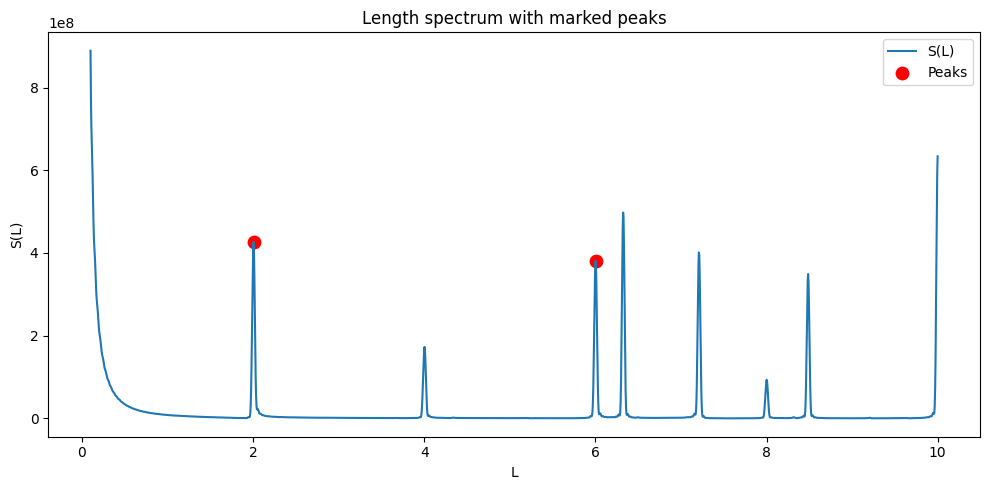

In [10]:
res = reconstruct_aspect_ratio_fourier_analysis(eigvals)
plot_peaks(res["L_axis"], res["spectral_density"], res["peak_idx"])